### Things to try
- Using Cabin and Ticket as features, but remove unique tickets and unique cabins. Do this over full data set
- Use a sklearn pipeline to simplify model
- Extract Title from name

In [27]:
import pandas as pd

# Preprocessing

### Import Data

In [28]:
train_input = pd.read_csv('train.csv')
test_input = pd.read_csv('test.csv')

y = train_input.Survived
passenger_ids = test_input.PassengerId

### Create Custom Features

In [29]:
# import re
# rare_list = ['Lady.', 'Countess.', 'Capt.', 'Col.', 'Don.', 'Dr.', 'Major.', 'Rev.', 'Sir.', 'Jonkheer.', 'Dona.']

# # Get Title from Name
# def get_title(text):
#     m = re.search(' ([A-Za-z]+)\.', text)
#     try:
#         title = m.group(0).strip()
#         if title in rare_list:
#             return 'Rare.'
#         elif title in ['Mlle.', 'Ms.']:
#             return 'Miss.'
#         elif title == 'Mme.':
#             return 'Mrs.'
#         else:
#             return title
#     except:
#         return 'None'

# train_input['Title'] = train_input['Name'].apply(get_title)
# test_input['Title'] = test_input['Name'].apply(get_title)

# print(train_input.Title.value_counts())

In [30]:
# # Create a column for each individual cabin letter
# def split_cabin(cabin):
#     return_vals = ['N/A'] * 4
#     if type(cabin) == str:
#         cabins = cabin.split(' ')
#         for i, c in enumerate(cabins):
#             if c[0].isalpha(): # First char is a letter
#                 return_vals[i] = c[0]
#             else:
#                 return_vals[i] = 'N/A'
#     else:
#         pass
    
#     return tuple(return_vals)

# train_input['C1'], train_input['C2'], train_input['C3'], train_input['C4'] = zip(*train_input['Cabin'].apply(split_cabin))
# test_input['C1'], test_input['C2'], test_input['C3'], test_input['C4'] = zip(*test_input['Cabin'].apply(split_cabin))

### Drop unwanted features

In [31]:
train_input = train_input.drop(['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin'], axis=1)
test_input = test_input.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

In [32]:
from sklearn.preprocessing import Imputer

def preprocess_data(X):
    # Add dataframe columns signifying where missing data is located......    
    cols_with_missing = (col for col in X.columns if X[col].isnull().any()) # Get columns with missing data

    for col in cols_with_missing:
        X[col + '_missing'] = X[col].isnull()
        
    # One hot encode data..................................................
    ohe_X = pd.get_dummies(X)
    
    return ohe_X

In [33]:
"""
Label missing data and one hot encode categorical data.
Preprocess all data together to one hot encode all categories in data. Otherwise, 
the test, validation, and training sets would all have subsets of the entire list of
available categories.
"""
full_set = preprocess_data(train_input.append(test_input, ignore_index=True))

In [34]:
# Split training and testing sets
train_processed = full_set[:len(train_input)].reset_index(drop=True)
test_processed = full_set[-len(test_input):].reset_index(drop=True)

### Train Test Split
Train test split before preprocessing to prevent data leakage

In [35]:
def impute_data(df):
    # Fit missing data using imputation....................................
    imputer = Imputer()
    imputed = pd.DataFrame(imputer.fit_transform(df))
    imputed.columns = df.columns
    
    return imputed

In [36]:
df_train_X = impute_data(train_processed)
df_test_X = impute_data(test_processed)

In [37]:
# Get just data, drop dataframe
train_X = df_train_X.values
test_X = df_test_X.values

# Train Data

### Find optimal model cycle count n_estimators

In [38]:
import matplotlib
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def get_cross_val_scores(plot_range, X, y, learning_rate=0.01):
    scores = []
    for n in plot_range:
        model = XGBRegressor(n_estimators=n, learning_rate=learning_rate)
        model.fit(X, y)
    
        n_scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error')
        scores += [-1*n_scores.mean()]
    return scores

# Grid Search For Best Solution

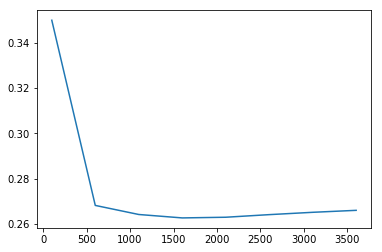

In [39]:
# Broad plot
test_range = range(100, 4000, 500)
val_mean_error = get_cross_val_scores(test_range, train_X, y)
plt.plot(test_range, val_mean_error)
plt.show()

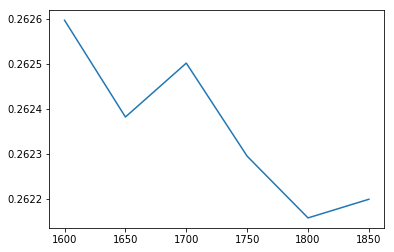

In [42]:
# Narrow plot
test_range = range(1600, 1900, 50)
val_mean_error = get_cross_val_scores(test_range, train_X, y)
plt.plot(test_range, val_mean_error)
plt.show()

### Get best n

In [43]:
idx_of_min_err = val_mean_error.index(min(val_mean_error))
best_err = val_mean_error[idx_of_min_err]
best_n = list(test_range)[idx_of_min_err]
print('Index: {0}, Value: {1:0.4f}, n_estimator: {2}'.format(idx_of_min_err, best_err, best_n))

Index: 4, Value: 0.2622, n_estimator: 1800


# Train Full Data Set

In [264]:
# Train on full data set with optimal model cycle count
model = XGBRegressor(n_estimators=1600, learning_rate=.01)
model.fit(train_X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1600,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

# Predict on Test Set

In [265]:
final_predictions = model.predict(test_X)

# Convert to boolean values
final_bool = [1 if p > 0.5 else 0 for p in final_predictions]

In [266]:
# Export predictions for submission
output = pd.DataFrame({'PassengerId': passenger_ids, 'Survived': final_bool})
output.to_csv('submission.csv', index=False)

# Partial Dependency Plots
How each feature affects the model

In [338]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import matplotlib
%matplotlib inline

partial_dependence_model = GradientBoostingRegressor()
partial_dependence_model.fit(titanic_X.values, y.values)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

### Age vs Survival Likelihood
More likely to survive if younger

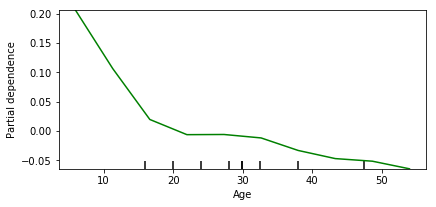

In [32]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[0], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)

### Fare Price vs Surival Likelihood
More likely to survive if payed more for fare

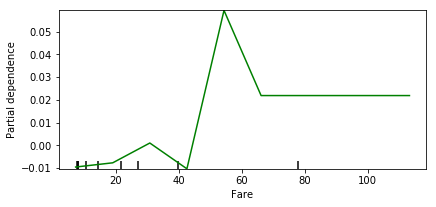

In [33]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[1], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)

### Parent Child Count vs Survival Likelihood
More likely to survive with fewer parent/child count (probably fewer children)

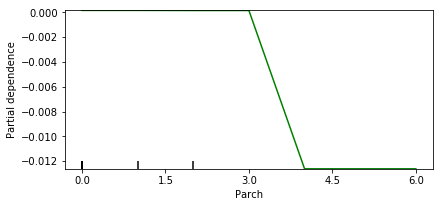

In [34]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[2], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)

### Travel Class vs Survival Likelihood
More likely to survive if 1st Class

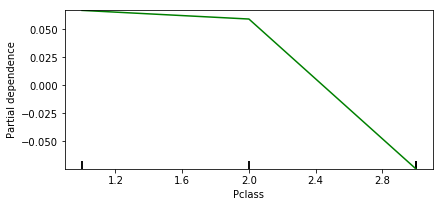

In [132]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[3], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)

### Sibling Count vs Survival Likelihood
Less siblings increased survival likelihood

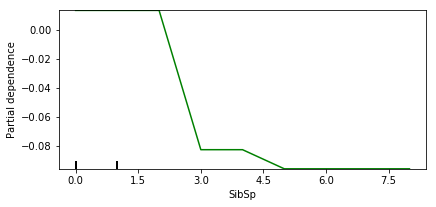

In [133]:
plotter = plot_partial_dependence(partial_dependence_model, 
                                  features=[4], # Column numbers of plots to show
                                  X=titanic_X.values, 
                                  feature_names=list(titanic_X.columns),
                                 grid_resolution=10)